In [1]:
import zipfile
import cv2
import numpy as np

faces = {}
with zipfile.ZipFile('attface.zip') as zip:
    for filename in zip.namelist():
        if not filename.endswith('.pgm'):
            continue
        with zip.open(filename) as img:
            faces[filename] = cv2.imdecode(np.frombuffer(img.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

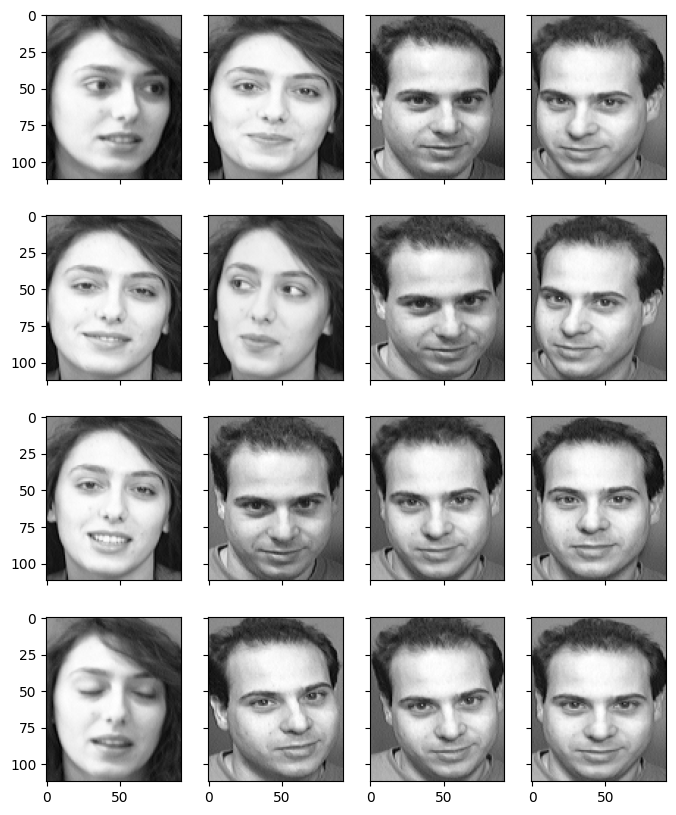

In [2]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceImg = list(faces.values())[-16:]
for i in range(16):
    axes[i%4][i//4].imshow(faceImg[i],cmap='gray')

plt.show()

In [3]:
faceShape = list(faces.values())[0].shape
faceShape

(112, 92)

In [4]:
# list(faces.keys())[:10]

In [5]:
classes = set(filename.split('/')[0] for filename in faces.keys())

print(len(classes))
print(len(faces))

40
400


In [6]:
faceMatrix = []
faceLabel = []

for key, val in faces.items():
    if key.startswith("s40/"):
        continue

    if key=="39/10.pgm":
        continue

    faceMatrix.append(val.flatten())
    faceLabel.append(key.split('/')[0])

# Create facematrix as (n_samples,n_pixels) matrix
faceMatrix = np.array(faceMatrix)
faceMatrix

array([[ 48,  49,  45, ...,  47,  46,  46],
       [ 34,  34,  33, ...,  37,  40,  33],
       [ 60,  60,  62, ...,  32,  34,  34],
       ...,
       [112, 109, 116, ...,  93,  88,  92],
       [111, 114, 112, ...,  88,  86,  92],
       [110, 112, 113, ...,  92,  87,  90]], dtype=uint8)

In [7]:
from sklearn.decomposition import PCA

pca = PCA().fit(faceMatrix)
# print(pca.explained_variance_ratio_)


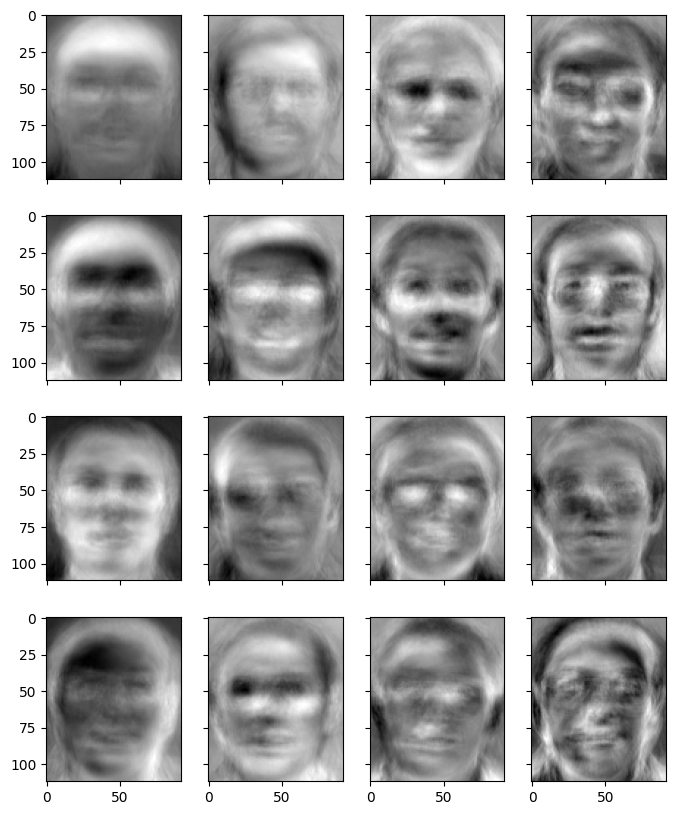

In [8]:
n_components = 50
eFaces = pca.components_[:n_components] 

fig, axes = plt.subplots(4,4, sharex=True, sharey=True, figsize=(8,10))
for i in range (16):
    axes[i%4][i//4].imshow(eFaces[i].reshape(faceShape), cmap='gray')

plt.show()

In [9]:
weights = eFaces@(faceMatrix - pca.mean_).T # type: ignore
weights.shape

(50, 390)

In [10]:
# weights = []
# for i in range(faceMatrix.shape[0]):
#     weight = []
#     for j in range(n_components):
#         w = eFaces[j]@(faceMatrix[i] - pca.mean_)
#         weight.append(w)
#     weights.append(weight)

testing

In [11]:
# Compute the Euclidean distances between the reference faces and the query image
query_img = faces["s39/10.pgm"].reshape(1, -1)
query_weight = pca.transform(query_img - pca.mean_).T
weights = np.array(weights)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)

# Find the index of the best matching face
if len(euclidean_distance) > 0:
    best_match = np.argmin(euclidean_distance)
    if best_match < len(faceImg):
        # Print the label and Euclidean distance of the best matching face
        print("Best match %s with Euclidean distance %f" % (faceImg[best_match], euclidean_distance[best_match]))
    else:
        print("Error: best match index out of range")
else:
    print("Error: no distances computed")


ValueError: operands could not be broadcast together with shapes (50,390) (390,1) 

In [ ]:
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceImg), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(faceMatrix[bestMatch].reshape(faceImg), cmap="gray")
axes[1].set_title("Best match")
plt.show()

NameError: name 'plt' is not defined

Showing sample faces


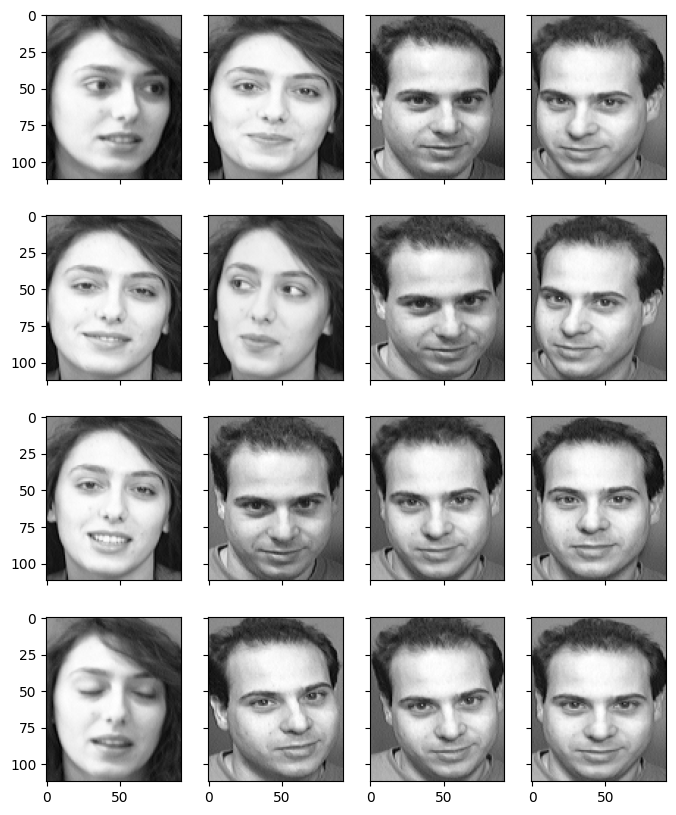

Face image shape: (112, 92)
Number of classes: 40
Number of images: 400
Showing the eigenfaces


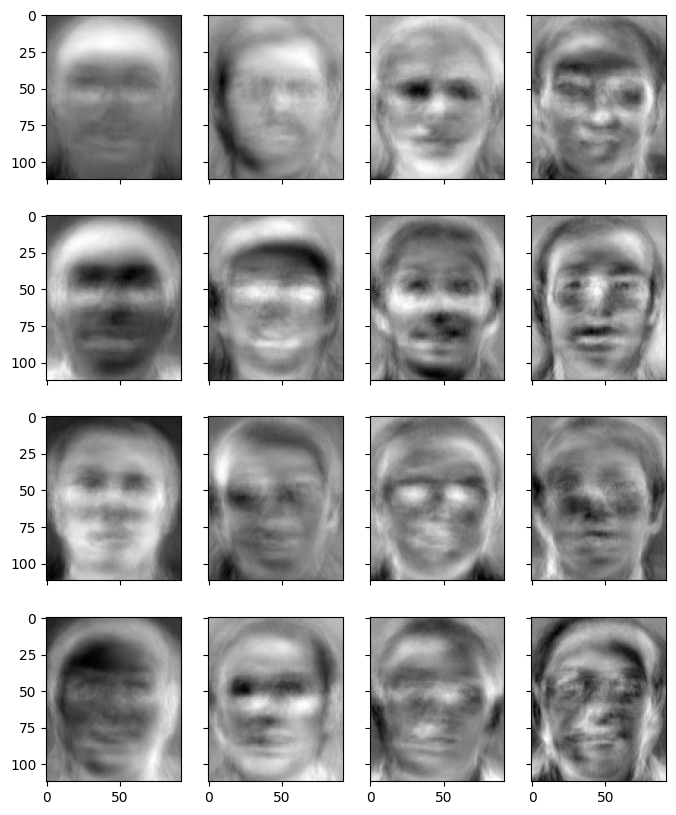

Shape of the weight matrix: (50, 389)
Best match s39 with Euclidean distance 1559.997137


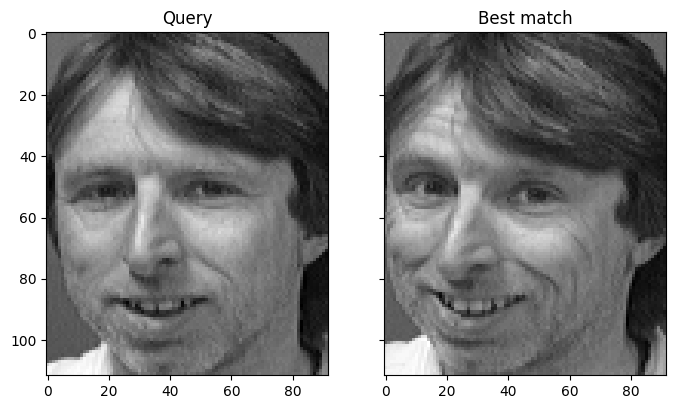

Best match s5 with Euclidean distance 2690.209330


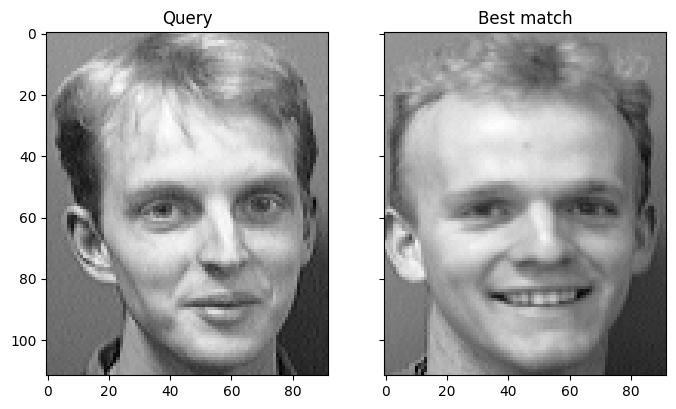

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
 
# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
 
# Show sample faces using matplotlib
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()
 
# Print some details
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)
 
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))
 
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])
 
# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)
 
# Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)
 
n_components = 50
eigenfaces = pca.components_[:n_components]
 
# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()
 
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)
 
# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()
 
# Test on out-of-sample image of new class
query = faces["s40/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()